In [1]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from scipy.stats import uniform
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from random import randint
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

# 1. Import Data

In [2]:
train_data = pd.read_csv("combined_train_with_features.csv")
valid_data = pd.read_csv("combined_valid_with_features.csv")

In [3]:
train_data.shape

(180, 103)

# 2. Fit Base Models (GB and AB) respectively

In [7]:
def split_data_index(data, K):
    
    index_arr = data.index.values
    shuffle_index_arr = copy.copy(index_arr)
    
    random.seed(222)
    shuffle_index_arr = shuffle_index_arr.reshape(-1,K)
    for arr in shuffle_index_arr:
        random.shuffle(arr)
    
    cv_outer = []
    for i in range(K):

        test_index = shuffle_index_arr[:,i]
        train_index = np.delete(shuffle_index_arr, i, axis=1).reshape(1,-1)[0]

        cv_outer.append([train_index, test_index])
    
    return cv_outer

In [8]:
def GB_random_search(X_train, y_train):
    
    model = GradientBoostingRegressor(random_state=222)
    
    params = {'n_estimators': np.arange(10,300,10),
                  'max_depth': np.arange(1, 5, 1),
                  'learning_rate': np.arange(0.005, 0.2, 0.001),   
                    }
    
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    search = RandomizedSearchCV(model,params,cv=cv_inner,scoring='neg_mean_absolute_error',verbose=0,n_jobs=-1,n_iter=100,refit=False,\
                               random_state=999)
    search.fit(X_train, y_train)

    model.set_params(**search.best_params_)
    print(search.best_params_)
    
    return model

In [9]:
def AB_random_search(X_train, y_train):

    model = AdaBoostRegressor(random_state=0)
        
    params = {'n_estimators': np.arange(10,500,10),
              'learning_rate': np.arange(0.005, 0.5, 0.001),
             }
    
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    search = RandomizedSearchCV(model,params,cv=cv_inner,scoring='neg_mean_absolute_error',verbose=0,n_jobs=-1,n_iter=100,refit=False,\
                               random_state=999)
    search.fit(X_train, y_train)

    model.set_params(**search.best_params_)
    print(search.best_params_)
    
    return model

In [12]:
def get_out_of_fold_predictions(data, K):
    
    scaled_data = scale_data(data)
    
    meta_X = []
    meta_y = []
    
    GB_models = []
    AB_models = []
    
    gb_pred = []
    ab_pred = []
    
    cv_outer = split_data_index(data, K)
    
    for train_index, test_index in cv_outer:
        X_train, y_train = data.iloc[train_index,6:].values, data.iloc[train_index,3].values
        X_test, y_test = data.iloc[test_index,6:].values, data.iloc[test_index,3].values
        
        meta_y.append(y_test)
        
        model_2 = GB_random_search(X_train, y_train)
        gb = clone(model_2)
        GB_models.append(gb)
        model_2.fit(X_train, y_train)
        hat_2 = model_2.predict(X_test)
        gb_pred.append(hat_2)
        
        model_3 = AB_random_search(X_train, y_train)
        rf = clone(model_3)
        AB_models.append(rf)
        model_3.fit(X_train, y_train)
        hat_3 = model_3.predict(X_test)
        ab_pred.append(hat_3)
    
    meta_X.append(np.hstack(gb_pred))
    meta_X.append(np.hstack(ab_pred))
    meta_X = np.vstack(meta_X).T
    
    meta_y = np.hstack(meta_y)
    
    return meta_X, meta_y, GB_models, AB_models

In [13]:
meta_X, meta_y, GB_models, AB_models = get_out_of_fold_predictions(train_data, 10)

{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 200, 'learning_rate': 0.442}
{'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.15}
{'n_estimators': 440, 'learning_rate': 0.47300000000000003}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 400, 'learning_rate': 0.341}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.128}
{'n_estimators': 280, 'learning_rate': 0.26}
{'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.115}
{'n_estimators': 340, 'learning_rate': 0.223}
{'n_estimators': 270, 'max_depth': 2, 'learning_rate': 0.08600000000000001}
{'n_estimators': 400, 'learning_rate': 0.31}
{'n_estimators': 230, 'max_depth': 2, 'learning_rate': 0.116}
{'n_estimators': 350, 'learning_rate': 0.456}
{'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.18000000000000002}
{'n_estimators': 270, 'learning_rate': 0.34500000000000003}
{'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.11800000000000001}
{'n_est

In [14]:
def fit_base_models(X, y, GB_models, AB_models):
    
    base_models = []
    
    model_2 = []
    for gm in GB_models:
        gm.fit(X, y)
        model_2.append(gm)
    base_models.append(model_2)
    
    model_3 = []
    for rf in AB_models:
        rf.fit(X, y)
        model_3.append(rf)
    base_models.append(model_3)
    
    return base_models

# 3. Fit the Meta Model

In [15]:
# fit a meta model
def fit_meta_model(meta_X, meta_y):
    model = LinearRegression()
    model.fit(meta_X, meta_y)
    return model

In [16]:
meta_model = fit_meta_model(meta_X, meta_y)

# 4. Predict the validation dataset

In [18]:
X_train = train_data.iloc[:,6:].values
y_train = train_data.iloc[:,3].values
X_valid = valid_data.iloc[:,6:].values
y_valid = valid_data.iloc[:,3].values

In [21]:
def validation_predictions(X_train, y_train, X_valid, GB_models, AB_models, meta_model):
    
    meta_X = []
    
    base_models = fit_base_models(X_train, y_train, GB_models, AB_models)
    
    
    for i, models in enumerate(base_models):
        
        if i == 0:
            preds = []
            for model in models:
                preds.append(model.predict(X_valid))
            y_hat = np.array(list(map(lambda x: sum(x)/len(x), np.array(preds).T)))
        
        elif i == 1:
            preds = []
            for model in models:
                preds.append(model.predict(X_valid))
            y_hat = np.array(list(map(lambda x: sum(x)/len(x), np.array(preds).T)))

        
        meta_X.append(y_hat.reshape(-1,1))
    
    meta_X = np.hstack(meta_X)
    predict = meta_model.predict(meta_X)
    
    return predict

In [22]:
y_hat = validation_predictions(X_train, y_train, X_valid, GB_models, AB_models, meta_model)

In [23]:
r2 = r2_score(y_valid, y_hat)

In [24]:
r2

0.9928110052036597

In [25]:
mean_squared_error(y_valid, y_hat,squared=False)

0.19630770691738259

In [26]:
mean_absolute_error(y_valid, y_hat)

0.14267570058213408

In [27]:
median_absolute_error(y_valid, y_hat)

0.09535313895215847

# 5. Plot y_true and y_predict

Text(0, 0.5, 'Predicted Retention Time (min)')

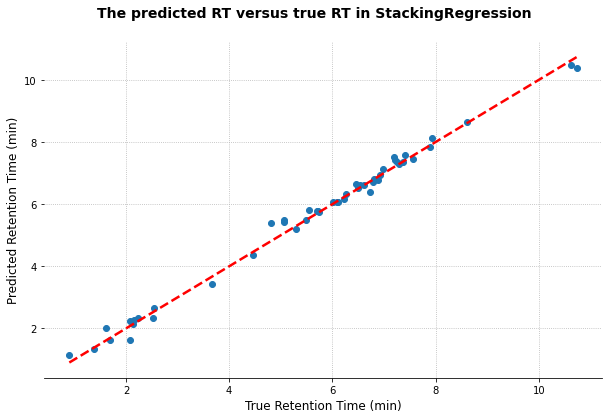

In [28]:
fig, ax = plt.subplots(figsize=(10,6.18))
fig.patch.set_facecolor('white')
ax.grid(True, which='major', linestyle=':')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(y_valid, y_hat, 'o')
ax.plot(y_valid, y_valid, '--', color='red', linewidth=2.5)
# ax.legend()

fig.suptitle("The predicted RT versus true RT in StackingRegression", y=0.96, fontsize=14, fontweight='bold')
ax.set_xlabel("True Retention Time (min)", fontdict={'fontsize': 12})
ax.set_ylabel("Predicted Retention Time (min)", fontdict={'fontsize': 12})


# fig.savefig("Stacking_validation_pred_true.png", dpi=300)

In [126]:
pred_df = pd.DataFrame(y_hat)

In [127]:
pred_df.columns = ['Stacking_pred']

In [128]:
pred_df.head()

,Stacking_pred
0,1.140361
1,1.336502
2,2.021183
3,1.629546
4,1.640292


In [129]:
pred_df.to_csv("Combined_Validation_Predict_Stacking.csv", index=False)